In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from datetime import datetime

In [3]:
time_start = datetime.now()

vgg19_model_fc1_features = pd.read_csv('vgg19_model_fc1_features.csv', sep=',', header=None)

print('This step took time:', datetime.now() - time_start)

This step took time: 0:00:52.566453


In [4]:
vgg19_model_fc1_features.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,3.094828,2.550586,1.647557,0.0,0.0,1.284944,4.473051,0.0,0.000000,0.0,...,0.000000,2.053498,2.249888,0.000000,1.680549,0.000000,6.533272,0.557587,2.230290,1.856253
1,4.302448,3.643159,2.365661,0.0,0.0,1.405371,3.830365,0.0,0.000000,0.0,...,0.000000,0.000000,1.833241,0.000000,0.651541,0.877186,6.996201,0.000000,1.502485,2.581533
2,1.310563,2.676150,0.000000,0.0,0.0,3.034392,2.832518,0.0,0.000000,0.0,...,0.107027,1.493688,4.274330,0.000000,1.228995,0.000000,4.333321,0.000000,4.639230,0.888631
3,5.516655,0.000000,2.521152,0.0,0.0,0.000000,6.429861,0.0,2.919165,0.0,...,0.000000,0.000000,0.000000,3.407895,0.000000,0.000000,5.767800,1.286931,0.000000,4.303179
4,5.193856,1.022700,0.761596,0.0,0.0,2.823310,1.901202,0.0,0.000000,0.0,...,0.000000,0.000000,2.264707,0.000000,2.462982,0.000000,3.978319,0.000000,2.107209,0.000000


In [5]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(vgg19_model_fc1_features.values)

In [6]:
time_start = datetime.now()

kmeans = KMeans(n_clusters=20, max_iter=30000, random_state=200)

print('This step took time:', datetime.now() - time_start)

This step took time: 0:00:00.003557


In [7]:
time_start = datetime.now()

kmeans.fit(X)

print('This step took time:', datetime.now() - time_start)

This step took time: 0:14:25.072024


In [9]:
time_start = datetime.now()

output = kmeans.predict(X) # cluster_labels

print('This step took time:', datetime.now() - time_start)

This step took time: 0:00:07.284817


## Identifying Palm Clusters
In this csv file, each row represents a ground observation. And the feature “pix_1” corresponds the column in the image, and “pix_2” corresponds to the row in the image. For example, the first data point has value pix_1 = 8132, pix_2 = 16017, which means its location is 16017th row, and 8132nd column in the image.

In [64]:
lfdp_ground_labels = pd.read_csv("LFDP_ground_labels.csv")
lfdp_ground_labels = lfdp_ground_labels.drop('Unnamed: 0', axis=1)

lfdp_palm = lfdp_ground_labels.loc[(lfdp_ground_labels['SPECIES'] == 'PREMON') & (lfdp_ground_labels['ALIVE'] == 'A')]
lfdp_palm = lfdp_palm[lfdp_palm['DIAM'] >= 20]
lfdp_palm.head()

,Unnamed: 0.1,STEM.TAG,QUAD,SUBQUAD,X,Y,SPECIES,CENSUS,DIAM,ALIVE,coords.x1,coords.x2,pix_1,pix_2
765,484772,6518.0,108,32,11.52,145.91,PREMON,6,20.0,A,265155.806401,254323.465978,8489,11719
2314,486384,17926.0,123,33,14.08,452.41,PREMON,6,20.7,A,265159.451067,254629.114280,8629,2547
3909,488055,171526.0,214,42,35.19,269.20,PREMON,6,20.2,A,265179.882966,254446.367808,9224,8033
4259,488423,14337.0,217,31,30.54,321.37,PREMON,6,20.0,A,265175.424270,254498.403076,9095,6471
4989,489173,17942.0,223,23,26.53,450.48,PREMON,6,20.8,A,265171.877860,254627.164549,9002,2606


In [65]:
palm_num = np.zeros(20)
for index, entry in lfdp_palm.iterrows():
    patch_col = entry['pix_1'] // 100
    patch_row = entry['pix_2'] // 100 

    patches_i = patch_row*200 + patch_col
    palm_num[output[patches_i]] += 1
    
    
cluster_size = np.zeros(20)
for i in range(len(output)):
    cluster_size[output[i]] += 1
    
palm_relevance = palm_num / (cluster_size + 1)
palm_relevance

array([0.00125156, 0.00661521, 0.00203978, 0.00226565, 0.00184332,
       0.00200468, 0.00137883, 0.        , 0.00193798, 0.        ,
       0.00078989, 0.01365188, 0.001002  , 0.        , 0.00564972,
       0.        , 0.0021488 , 0.00126944, 0.00088994, 0.00188071])

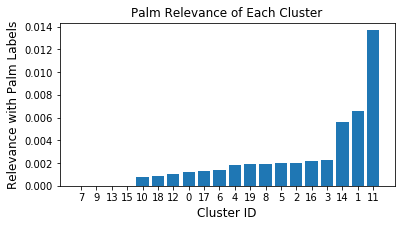

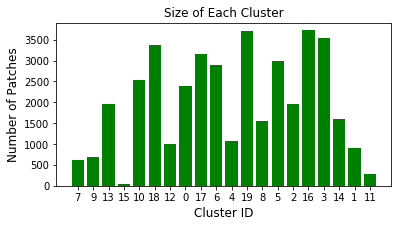

In total, PREMON density is 0.00185


In [67]:
sorted_cluster = np.array(sorted(range(len(palm_relevance)), key=lambda k: palm_relevance[k]), dtype=str)
sorted_palm_relevance = np.sort(palm_relevance)

plt.figure(figsize=(6, 3))
plt.bar(sorted_cluster, sorted_palm_relevance)
plt.title('Palm Relevance of Each Cluster')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Relevance with Palm Labels', fontsize=12)
plt.show()

plt.figure(figsize=(6, 3))
plt.bar(sorted_cluster, cluster_size[sorted_cluster.astype(int)], color='green')
plt.title('Size of Each Cluster')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Patches', fontsize=12)
plt.show()

print('In total, PREMON density is', palm_num.sum()/cluster_size.sum())

### Patches in Palm Cluster(s) Visualization
we will visualize top 3 for now

In [69]:
import cv2
from itertools import product

# need to actually get the patches again, so that we can pick the correct patches and stitch them up to create our visualization
img = cv2.imread("shadow_remove.jpg")
patches = [img[i*100:(i+1)*100,j*100:(j+1)*100] for i, j in product(range(int(img.shape[0]/100)), range(int(img.shape[1]/100)))]
patches = np.asarray(patches)

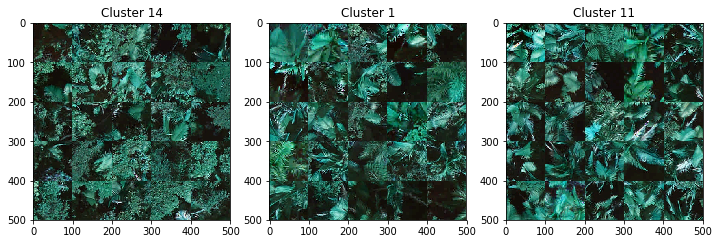

In [125]:
import random

fig = plt.figure(figsize=(12,12)) 

subplot_i = 1
for cluster in sorted_cluster.astype(int)[-3:]:
    # we will view a random 25 patches for each cluster
    indices = [i for i, x in enumerate(output) if x == cluster]
    indices_pos = random.sample(range(len(indices)), 25) # positions of selected elements in indices

    new_img = np.zeros(shape=(500, 500, 3), dtype=int)
    for i in range(5):
        for j in range(5):
            patch_id = i*5 + j # basically acts like a variable that goes from 0 to 24 consecutively
            new_img[i*100:(i+1)*100, j*100:(j+1)*100] = patches[indices[indices_pos[patch_id]],:,:,:]
    
    # let's save the image in the cluster_images folder
    cv2.imwrite('cluster_images/vgg19_model_fc1_palm_cluster' + str(cluster) + '.jpg', new_img)
    
    fig.add_subplot(1,3,subplot_i), plt.imshow(new_img), plt.title('Cluster ' + str(cluster))
    subplot_i+=1

plt.show()

## Identifying Cecropia Clusters

In [126]:
# lfdp_ground_labels = pd.read_csv("LFDP_ground_labels.csv")
# lfdp_ground_labels = lfdp_ground_labels.drop('Unnamed: 0', axis=1)

# don't need to do the above if you already identified Palm Clusters in the previous step

lfdp_cecropia = lfdp_ground_labels.loc[(lfdp_ground_labels['SPECIES'] == 'CECSCH') & (lfdp_ground_labels['ALIVE'] == 'A')]
lfdp_cecropia = lfdp_cecropia[lfdp_cecropia['DIAM'] >= 20]
lfdp_cecropia.head()

,Unnamed: 0.1,STEM.TAG,QUAD,SUBQUAD,X,Y,SPECIES,CENSUS,DIAM,ALIVE,coords.x1,coords.x2,pix_1,pix_2
258,484243,807.0,103,11,4.24,43.12,CECSCH,6,22.4,A,265148.171075,254220.974535,8249,14794
629,484628,29158.0,106,44,17.12,118.78,CECSCH,6,27.9,A,265161.302736,254296.399638,8651,12532
851,484870,48491.0,109,31,10.64,160.46,CECSCH,6,24.8,A,265154.979207,254337.977563,8465,11283
992,485014,134310.0,110,41,19.70,181.65,CECSCH,6,27.0,A,265164.102526,254359.090799,8741,10650
993,485015,134312.0,110,41,17.51,182.22,CECSCH,6,29.3,A,265161.917427,254359.663633,8676,10633


In [127]:
cecropia_num = np.zeros(20)
for index, entry in lfdp_cecropia.iterrows():
    patch_col = entry['pix_1'] // 100
    patch_row = entry['pix_2'] // 100 

    patches_i = patch_row*200 + patch_col
    cecropia_num[output[patches_i]] += 1
    
    
# cluster_size = np.zeros(20)
# for i in range(len(output)):
#     cluster_size[output[i]] += 1

# don't need to do the above if you already identified Palm Clusters in the previous step
    
cecropia_relevance = cecropia_num / (cluster_size + 1)
cecropia_relevance

array([0.0175219 , 0.00441014, 0.00611933, 0.01416029, 0.03686636,
       0.01570331, 0.02275078, 0.008     , 0.00904393, 0.00146843,
       0.00829384, 0.00682594, 0.00701403, 0.00306905, 0.01820465,
       0.        , 0.01208703, 0.00825135, 0.00889944, 0.01101558])

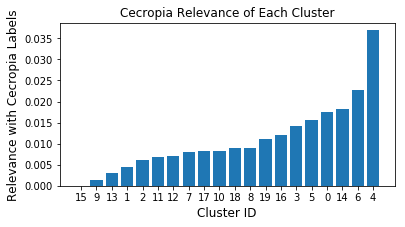

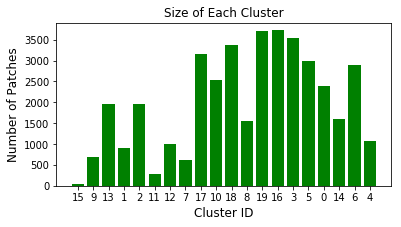

In total, CECSCH density is 0.0122


In [128]:
sorted_cluster = np.array(sorted(range(len(cecropia_relevance)), key=lambda k: cecropia_relevance[k]), dtype=str)
sorted_cecropia_relevance = np.sort(cecropia_relevance)

plt.figure(figsize=(6, 3))
plt.bar(sorted_cluster, sorted_cecropia_relevance)
plt.title('Cecropia Relevance of Each Cluster')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Relevance with Cecropia Labels', fontsize=12)
plt.show()

plt.figure(figsize=(6, 3))
plt.bar(sorted_cluster, cluster_size[sorted_cluster.astype(int)], color='green')
plt.title('Size of Each Cluster')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Patches', fontsize=12)
plt.show()

print('In total, CECSCH density is', cecropia_num.sum()/cluster_size.sum())

### Patches in Cecropia Cluster(s) Visualization
we will visualize top 3 for now

In [129]:
# import cv2
# from itertools import product

# # need to actually get the patches again, so that we can pick the correct patches and stitch them up to create our visualization
# img = cv2.imread("shadow_remove.jpg")
# patches = [img[i*100:(i+1)*100,j*100:(j+1)*100] for i, j in product(range(int(img.shape[0]/100)), range(int(img.shape[1]/100)))]
# patches = np.asarray(patches)

# don't need to do this if you already identified Palm Clusters in the previous step

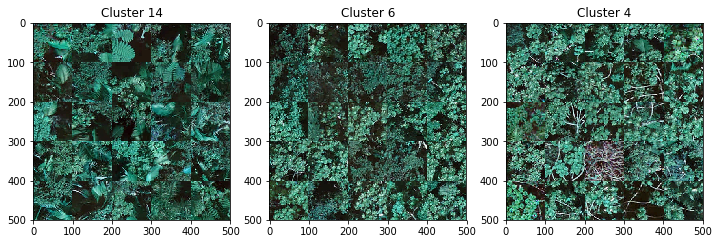

In [130]:
import random

fig = plt.figure(figsize=(12,12)) 

subplot_i = 1
for cluster in sorted_cluster.astype(int)[-3:]:
    # we will view a random 25 patches for each cluster
    indices = [i for i, x in enumerate(output) if x == cluster]
    indices_pos = random.sample(range(len(indices)), 25) # positions of selected elements in indices

    new_img = np.zeros(shape=(500, 500, 3), dtype=int)
    for i in range(5):
        for j in range(5):
            patch_id = i*5 + j # basically acts like a variable that goes from 0 to 24 consecutively
            new_img[i*100:(i+1)*100, j*100:(j+1)*100] = patches[indices[indices_pos[patch_id]],:,:,:]
    
    # let's save the image in the cluster_images folder
    cv2.imwrite('cluster_images/vgg19_model_fc1_cecropia_cluster' + str(cluster) + '.jpg', new_img)
    
    fig.add_subplot(1,3,subplot_i), plt.imshow(new_img), plt.title('Cluster ' + str(cluster))
    subplot_i+=1

plt.show()